In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import shap
import os
import geopandas as gpd

In [2]:
## load the data

full_df = pd.read_pickle("2010_data_interpolated.pkl")
full_df=full_df.drop(columns=['location_name', 'fips', 'year', 'NAME'],axis=1)
pd.set_option('display.max_columns', None)
full_df

,MeanLifeExpectency,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,75.728489,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,4.351527e-06,4.876077e-09,3.969704e-06,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,2.926953e-06,25.761255,25.615093,2.107318e-06,4.285939e-06,3.294435e-06,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,1.009535e-06,0.000008,1.630353e-06
1,77.826608,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,3.582948e-06,4.927685e-09,2.205362e-06,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,2.456049e-06,27.814162,27.673807,2.637130e-06,5.442802e-06,4.337687e-06,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,1.940944e-06,0.000008,1.191268e-06
2,75.841973,284.030677,291.049553,0.006414,0.018000,0.010646,4.105077,2.401998,101691.374779,0.073921,1.517368e-08,2.077828e-08,0.007873,0.878999,248.936151,0.006123,0.067726,100206.359317,272.703123,0.166579,0.000885,0.000003,4.185584e-06,4.877634e-09,3.576529e-06,0.009894,0.000005,0.000003,4.403563e-07,0.006526,0.000009,6.843867e-07,2.568678e-06,26.033231,25.892798,2.087401e-06,4.249902e-06,3.340465e-06,1.435932e-07,0.000002,5.378396e-07,0.000013,2.381366e-07,0.000016,1.119412e-06,0.000008,1.224486e-06
3,73.705432,283.399627,290.639088,0.006220,0.018000,0.010239,3.806542,2.708516,101697.654467,0.077070,1.473672e-08,2.024184e-08,0.007104,0.878525,274.633550,0.005328,0.073269,100126.232531,272.649834,0.173902,0.000894,0.000003,4.347974e-06,4.880969e-09,3.728783e-06,0.009884,0.000005,0.000004,5.119491e-07,0.006629,0.000009,7.059465e-07,3.335762e-06,25.483006,25.334140,2.013939e-06,4.098991e-06,3.148080e-06,1.258605e-07,0.000003,5.349512e-07,0.000013,2.197643e-07,0.000015,8.923379e-07,0.000008,2.044144e-06
4,75.753407,282.901290,289.815983,0.006111,0.018000,0.008443,3.248142,2.783056,101709.279262,0.077202,1.520853e-08,2.099272e-08,0.006220,0.877274,276.605380,0.006145,0.074806,99117.579532,272.616992,0.172783,0.000889,0.000003,4.065276e-06,4.892594e-09,2.665721e-06,0.009779,0.000005,0.000004,5.297614e-07,0.006687,0.000009,7.184297e-07,3.732430e-06,24.141938,23.988644,1.665682e-06,3.365222e-06,2.598917e-06,1.289331e-07,0.000003,5.203605e-07,0.000013,1.997636e-07,0.000013,7.163518e-07,0.000008,2.475384e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,77.582422,268.699994,278.306938,0.004731,0.018000,0.004273,2.963378,0.521521,101612.298364,0.043443,7.211313e-09,1.085390e-08,0.004944,0.797428,288.800929,0.016638,0.023680,78671.597311,268.952507,0.081071,0.000645,0.000003,1.057181e-06,4.940441e-09,8.240240e-08,0.007670,0.000003,0.000002,4.936414e-07,0.006922,0.000005,5.097700e-07,1.752316e-06,7.935474,7.862793,5.575145e-07,1.294505e-06,3.974618e-06,9.234859e-08,0.000002,4.103250e-07,0.000008,2.020761e-07,0.000012,8.884089e-07,0.000003,1.334658e-06
3123,83.771012,267.448043,273.873965,0.004740,0.018000,0.001595,2.573796,2.378314,101622.979506,0.044644,6.583338e-09,9.402720e-09,0.005779,0.806610,309.101498,0.099861,0.021002,74693.719536,268.553249,0.077760,0.000607,0.000002,8.023640e-07,4.846817e-09,7.718545e-08,0.007256,0.000002,0.000001,2.632511e-07,0.007037,0.000004,4.883845e-07,5.185750e-07,6.433924,6.340060,2.703968e-07,5.

In [3]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [4]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.53


In [5]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()

In [6]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')

RMSE scores for each fold: [1.36741048 1.5324803  1.52153006 1.42272576]
Mean RMSE score: 1.4610366484159623
Standard deviation of RMSE scores: 0.06891522381273817


In [7]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'max_features': [10,20,30], 'max_depth':[100, 150, 200],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
CPU times: total: 17min 6s
Wall time: 1min 51s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200],
                          'max_features': [10, 20, 30],
                          'min_samples_split': [5, 10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [8]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=100, max_features=10, min_samples_split=5,
                      n_jobs=-1, oob_score=True)

In [9]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [10]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.66


In [11]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.62


In [12]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.51


In [13]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.92


In [14]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.62


In [15]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.91
The adjusted test r_sq ::: 0.58


In [16]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

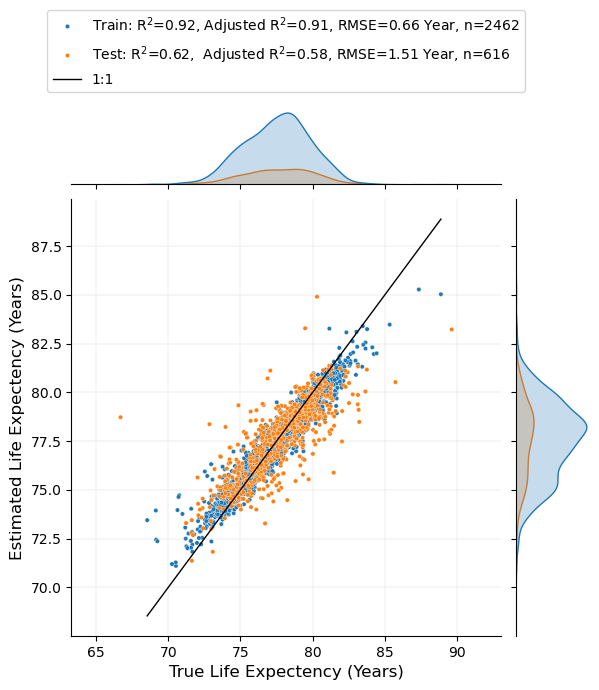

In [17]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  



g.ax_joint.legend(handles=handles,  
    labels=[ f'Train: R$^2$={corr_train}, Adjusted R$^2$={train_adjusted_r2}, RMSE={rmse_train} Year, n={len(X_train)}', 
        f'Test: R$^2$={corr_test},  Adjusted R$^2$={test_adjusted_r2}, RMSE={rmse_test} Year, n={len(X_test)}','1:1'],
                        title=None)

sns.move_legend(g.ax_joint, "upper center", bbox_to_anchor=(0.5, 1.45))

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

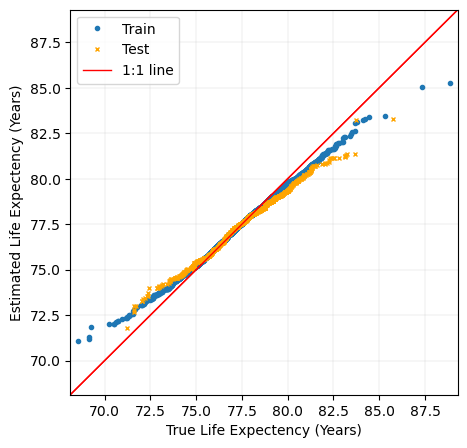

In [18]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

## Find feature importance on the train set

In [19]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5
train_permutation

{'importances_mean': array([ 8.11295582e-02,  6.73360384e-02,  2.85543069e-02,  8.27545327e-03,
         6.64577738e-02,  3.24438473e-02,  4.96374202e-02,  1.66561169e-01,
         3.79912253e-02, -9.86864911e-17, -4.93432455e-17,  3.28840885e-02,
         3.54897363e-02,  4.55056083e-02,  3.12896206e-02,  7.29917326e-02,
         3.47166593e-02,  4.50118319e-02,  3.62729875e-02,  4.27999812e-02,
         1.60903651e-04,  1.43761715e-03, -4.93432455e-17,  8.56346149e-03,
         3.63790390e-02,  3.06021315e-03,  7.91621361e-03,  1.88689884e-04,
         5.74341787e-02,  4.42027891e-03,  6.57048566e-06,  3.67187206e-03,
         5.32838809e-02,  5.96826708e-02,  5.12477384e-04,  2.48784384e-03,
         5.26725375e-03, -8.63506797e-17,  2.26818500e-03,  5.81053482e-06,
         7.82788968e-03,  9.53366392e-05,  1.42935999e-02,  3.78558406e-03,
         3.80251371e-03,  4.22126377e-03]),
 'importances_std': array([1.28164264e-03, 1.45805595e-03, 8.21213171e-04, 3.40467806e-04,
        2

In [20]:
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

In [21]:
mean_val

array([ 8.11295582e-02,  6.73360384e-02,  2.85543069e-02,  8.27545327e-03,
        6.64577738e-02,  3.24438473e-02,  4.96374202e-02,  1.66561169e-01,
        3.79912253e-02, -9.86864911e-17, -4.93432455e-17,  3.28840885e-02,
        3.54897363e-02,  4.55056083e-02,  3.12896206e-02,  7.29917326e-02,
        3.47166593e-02,  4.50118319e-02,  3.62729875e-02,  4.27999812e-02,
        1.60903651e-04,  1.43761715e-03, -4.93432455e-17,  8.56346149e-03,
        3.63790390e-02,  3.06021315e-03,  7.91621361e-03,  1.88689884e-04,
        5.74341787e-02,  4.42027891e-03,  6.57048566e-06,  3.67187206e-03,
        5.32838809e-02,  5.96826708e-02,  5.12477384e-04,  2.48784384e-03,
        5.26725375e-03, -8.63506797e-17,  2.26818500e-03,  5.81053482e-06,
        7.82788968e-03,  9.53366392e-05,  1.42935999e-02,  3.78558406e-03,
        3.80251371e-03,  4.22126377e-03])

In [22]:
mean_importance

[(0.1665611687165648, 'msl'),
 (0.0811295582107077, 'd2m'),
 (0.07299173260989118, 'suaod550'),
 (0.06733603838420725, 't2m'),
 (0.06645777376885678, 'duaod550'),
 (0.059682670761943016, 'tcwv'),
 (0.05743417874000171, 'gtco3'),
 (0.053283880883302985, 'tcw'),
 (0.04963742019468807, 'lai_lv'),
 (0.04550560829126002, 'rsn'),
 (0.04501183193580765, 'tsn'),
 (0.04279998121238657, 'tcco'),
 (0.037991225320432705, 'omaod550'),
 (0.036379039019082744, 'tc_ch4'),
 (0.0362729875331598, 'aod550'),
 (0.03548973631512031, 'asn'),
 (0.03471665934635396, 'sp'),
 (0.03288408845147433, 'ssaod550'),
 (0.032443847272537005, 'lai_hv'),
 (0.03128962063720591, 'sd'),
 (0.02855430693106757, 'bcaod550'),
 (0.014293599919869227, 'aermssssm'),
 (0.008563461486110584, 'tc_c5h8'),
 (0.008275453269233537, 'chnk'),
 (0.007916213612732129, 'tcno2'),
 (0.007827889682111245, 'aermssomhphob'),
 (0.005267253748892882, 'aermssdul'),
 (0.004420278907781738, 'tc_pan'),
 (0.004221263770028837, 'aermssso2'),
 (0.0038025137

In [23]:
std_importance

[(0.005024061823268967, 'msl'),
 (0.002202902456045707, 'duaod550'),
 (0.0021531019729609567, 'gtco3'),
 (0.0017509678649222868, 'omaod550'),
 (0.0016067200835169766, 'lai_lv'),
 (0.0015581492245113112, 'tcco'),
 (0.0015555364745058647, 'suaod550'),
 (0.001458055949928756, 't2m'),
 (0.001319093152642519, 'tcw'),
 (0.0012816426375761635, 'd2m'),
 (0.0012701760251024388, 'tcwv'),
 (0.0011292104428046999, 'sd'),
 (0.0011239804642558882, 'ssaod550'),
 (0.0009940817380762077, 'rsn'),
 (0.0009365464564956422, 'tsn'),
 (0.0008938408669064965, 'asn'),
 (0.0008589943451854997, 'aod550'),
 (0.0008212131711899846, 'bcaod550'),
 (0.0006984816677130353, 'sp'),
 (0.0006876493233066902, 'lai_hv'),
 (0.0006796973659390678, 'aermssssm'),
 (0.0005516727336463828, 'tcno2'),
 (0.0005239606175615125, 'tc_ch4'),
 (0.000490494072014489, 'aermssomhphob'),
 (0.0004689678352772635, 'tc_c5h8'),
 (0.0003586399581606381, 'aermssdul'),
 (0.0003404678056680015, 'chnk'),
 (0.00025951851339312443, 'aermssssl'),
 (0.00

In [24]:
mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

print(train_FI)

          Feature   Mean Weight  Standard Deviation
7             msl  1.665612e-01        5.024062e-03
0             d2m  8.112956e-02        1.281643e-03
15       suaod550  7.299173e-02        1.555536e-03
1             t2m  6.733604e-02        1.458056e-03
4        duaod550  6.645777e-02        2.202902e-03
33           tcwv  5.968267e-02        1.270176e-03
28          gtco3  5.743418e-02        2.153102e-03
32            tcw  5.328388e-02        1.319093e-03
6          lai_lv  4.963742e-02        1.606720e-03
13            rsn  4.550561e-02        9.940817e-04
17            tsn  4.501183e-02        9.365465e-04
19           tcco  4.279998e-02        1.558149e-03
8        omaod550  3.799123e-02        1.750968e-03
24         tc_ch4  3.637904e-02        5.239606e-04
18         aod550  3.627299e-02        8.589943e-04
12            asn  3.548974e-02        8.938409e-04
16             sp  3.471666e-02        6.984817e-04
11       ssaod550  3.288409e-02        1.123980e-03
5          l

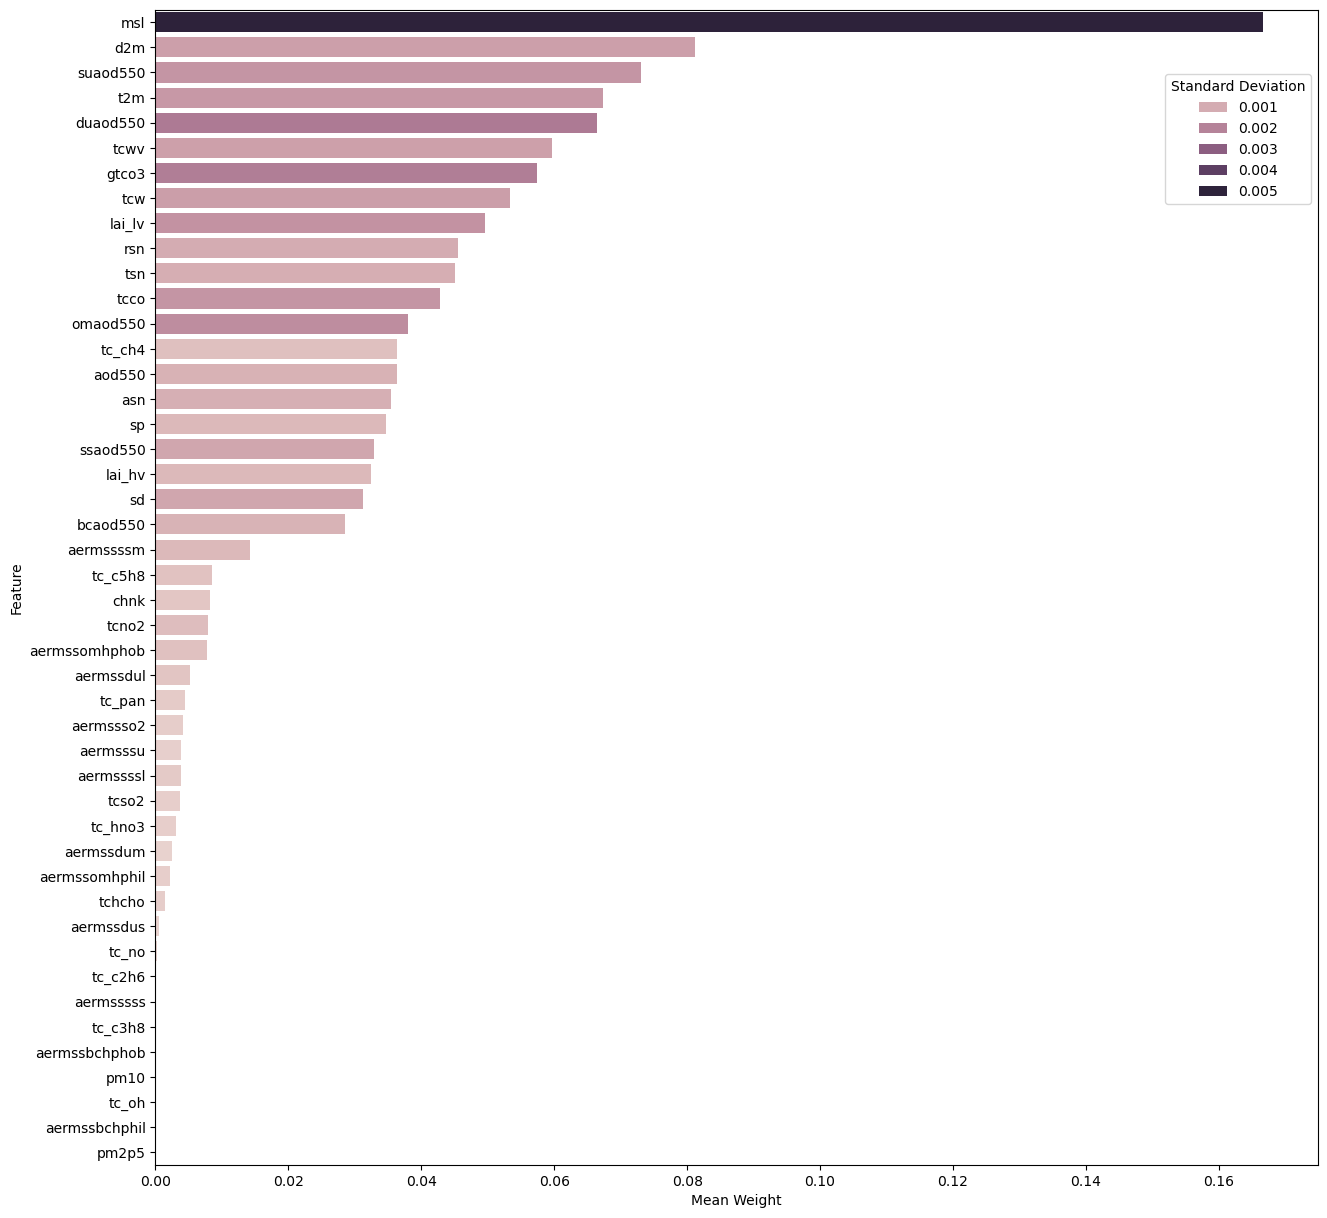

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.95))

## Find permutation importance in test set

In [26]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5

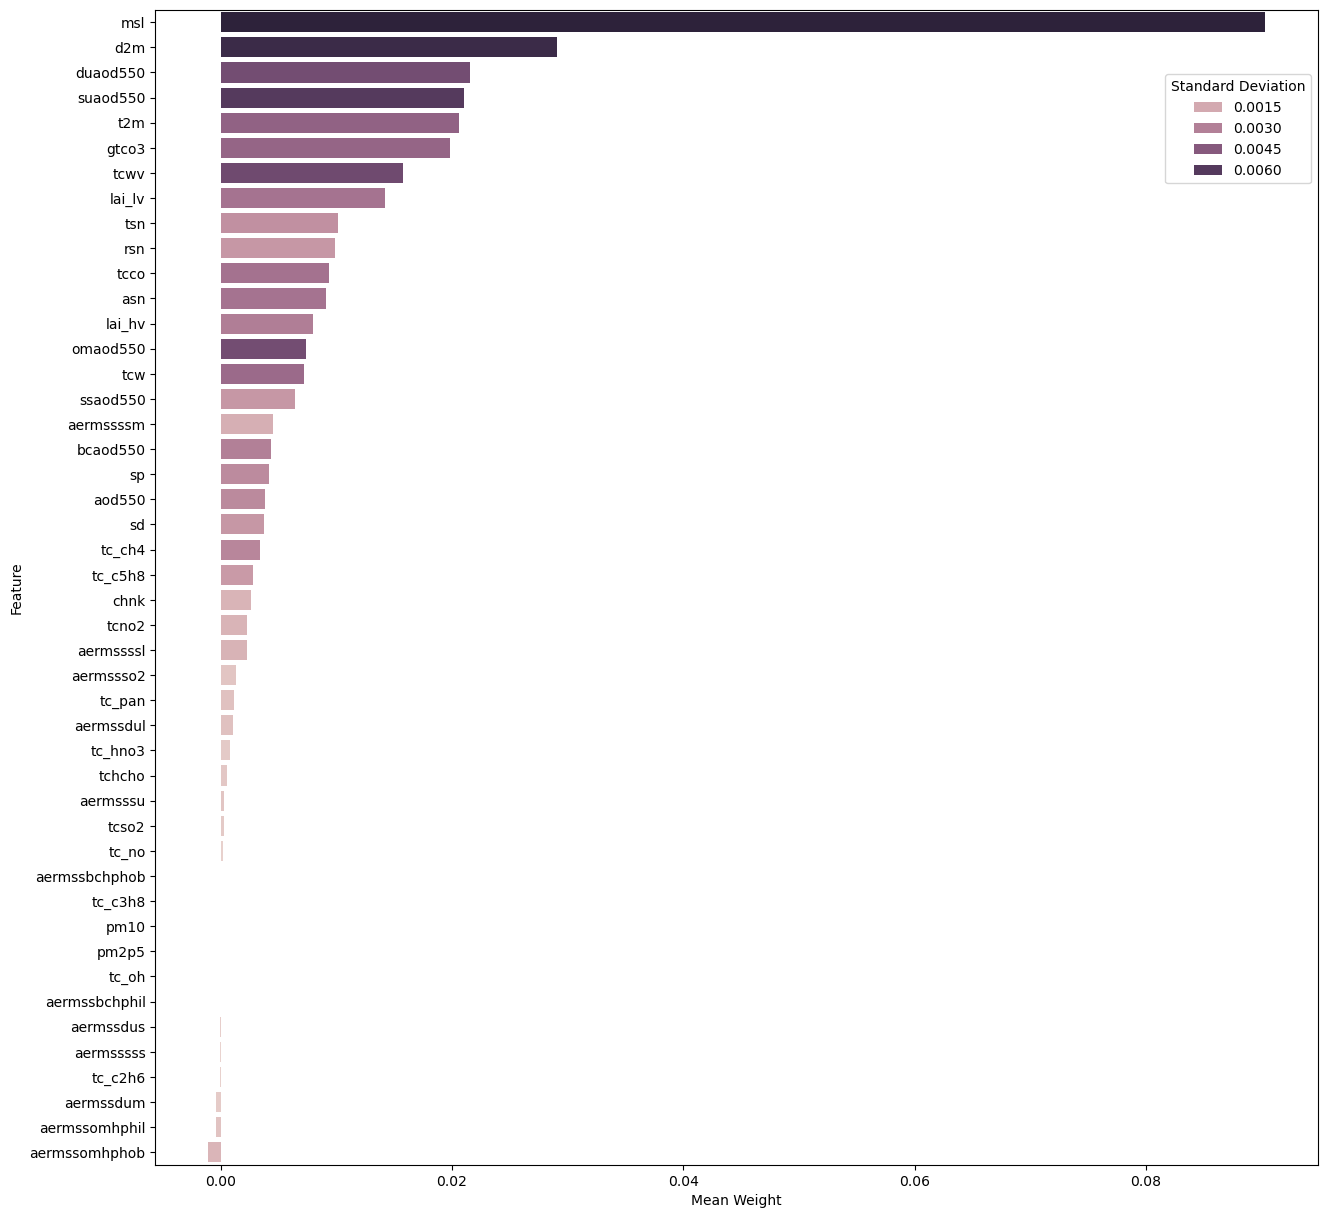

In [27]:
mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.95))

In [28]:
## in train set

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)

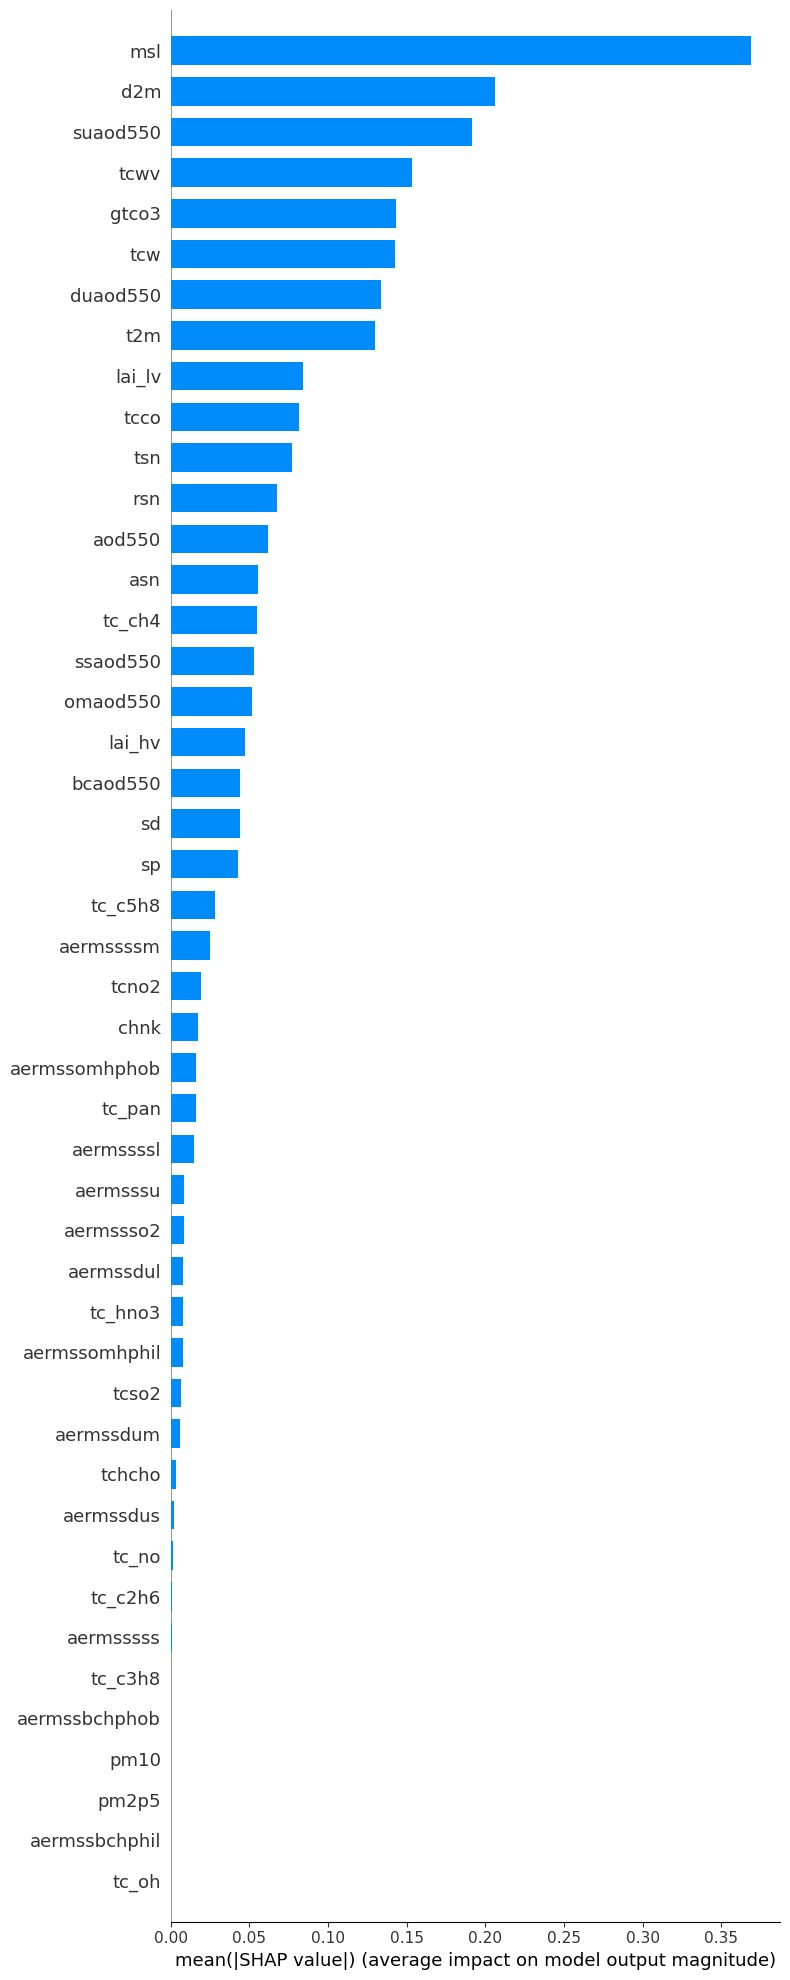

In [29]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

In [30]:
## in test set
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)

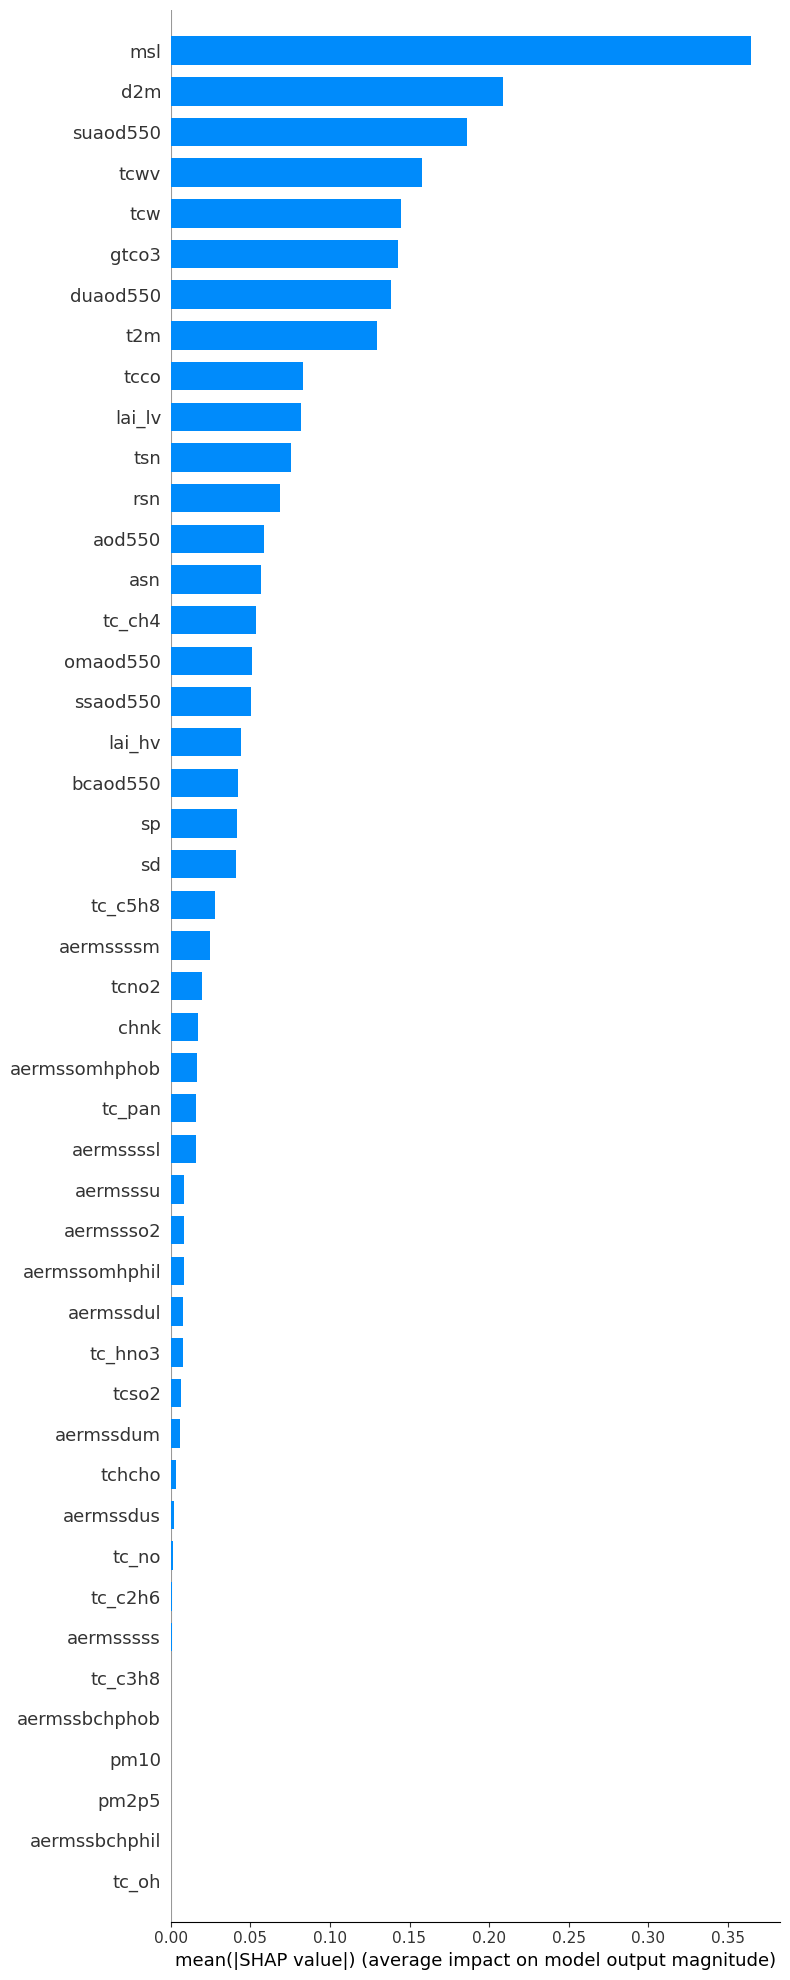

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

# Plot True Values on a map

In [32]:
##  load the county shapefile

SHAPE_PATH = os.path.join("County_shapefile",'gz_2010_us_050_00_500k.shp')
county_gdf = gpd.read_file(SHAPE_PATH)

county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873..."
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619..."
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090..."
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994..."
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663..."


In [33]:
## lets create the fips column in the dataframe which is the sum of state and county both as dtype string.
## Note: not a numerical sum
## This step is necessary because there can be several counties with idential names. 

county_gdf['fips']=county_gdf['STATE'] + county_gdf['COUNTY']
county_gdf.dtypes
## convert the data type
county_gdf['fips']=county_gdf['fips'].astype(str).astype(int)
county_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041


In [34]:
full_df = pd.read_pickle("2010_data_interpolated.pkl")
full_df.head(2)

,location_name,fips,year,MeanLifeExpectency,NAME,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,0.000004,4.876077e-09,0.000004,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,0.000003,25.761255,25.615093,0.000002,0.000004,0.000003,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,0.000001,0.000008,0.000002
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,0.000004,4.927685e-09,0.000002,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,0.000002,27.814162,27.673807,0.000003,0.000005,0.000004,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,0.000002,0.000008,0.000001


In [35]:
true_LE = full_df[['fips', 'MeanLifeExpectency']] ## get only fips and MeanLifeExpectancy column
type(true_LE)

pandas.core.frame.DataFrame

In [36]:
gpd_df = pd.merge(county_gdf, true_LE, on='fips', how='left') 
gpd_df= gpd_df.dropna()
gpd_df.head(2)
## It is VERY IMPORTANT that the left dataframe that is merged is a Geopandas Dataframe
## Not pandas dataframe. While a Geopandas dataframe can be easily plotted, a pandas  
## even if it consists Geometry column, pandas will not recognize it and it will not be plotted

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,MeanLifeExpectency
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.109806
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,76.675374


In [37]:
## Lets load the shapefile

SHAPE_PATH = os.path.join("State_shapefile",'cb_2018_us_state_500k.shp')
state_shape = gpd.read_file(SHAPE_PATH)

print('The CRS of the SHAPE file is:', state_shape.crs)

The CRS of the SHAPE file is: EPSG:4269


In [38]:
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


In [39]:
## include only CONUS shapefile

remove_state = ['Alaska', 'District of Columbia', 'American Samoa', 'United States Virgin Islands', 'Hawaii', 'Guam', 
                  'Commonwealth of the Northern Mariana Islands', 'Puerto Rico' ]

# Remove rows where the 'NAME' column contains any value from strings
state_shape = state_shape[~state_shape['NAME'].isin(remove_state)]
state_shape.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


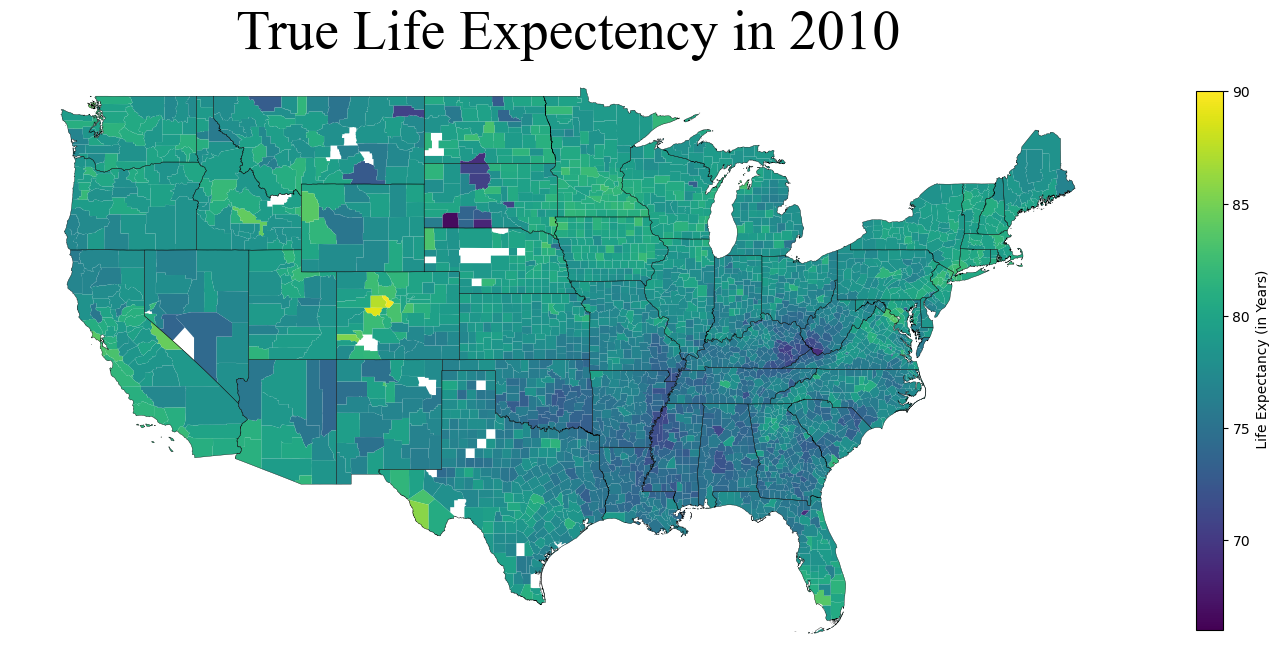

In [40]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
gpd_df.plot(ax=ax,column='MeanLifeExpectency', legend=True, legend_kwds={"label": " Life Expectancy (in Years)", 
                                                                               "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('True Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Plot estimated life expectancy in train and test data

In [41]:
train_prediction

array([74.87834638, 80.78001021, 78.43570084, ..., 77.59741296,
       80.9963471 , 81.26153134])

In [42]:
y_train

1079    74.841636
2952    81.721928
942     79.045485
514     74.023150
138     73.902156
          ...    
1542    77.278702
1118    77.849549
2264    77.561261
565     80.885187
1351    81.652548
Name: MeanLifeExpectency, Length: 2462, dtype: float64

In [43]:
y_train_df=pd.DataFrame([y_train]).T
y_train_df['Train Prediction']=train_prediction
y_train_df

,MeanLifeExpectency,Train Prediction
1079,74.841636,74.878346
2952,81.721928,80.780010
942,79.045485,78.435701
514,74.023150,74.395342
138,73.902156,73.712027
...,...,...
1542,77.278702,77.578195
1118,77.849549,77.581413
2264,77.561261,77.597413
565,80.885187,80.996347


In [44]:
y_test_df=pd.DataFrame([y_test]).T
y_test_df
y_test_df['Test Prediction']=test_prediction
y_test_df

,MeanLifeExpectency,Test Prediction
1930,77.442381,76.961913
2253,78.457276,79.479869
482,76.547465,76.558005
441,77.023391,78.044219
3009,76.519842,78.576419
...,...,...
2702,76.358825,77.203460
2379,81.043055,79.852639
2502,74.282604,76.398398
1462,73.951751,74.831780


In [45]:
y_train_df=y_train_df.drop('MeanLifeExpectency', axis=1)
y_test_df=y_test_df.drop('MeanLifeExpectency', axis=1)

In [46]:
df_train = pd.merge(full_df, ## merge index with original data
                    y_train_df, left_index=True, right_index=True, how='left') 
df_train.head()

,location_name,fips,year,MeanLifeExpectency,NAME,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Train Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,0.000004,4.876077e-09,0.000004,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,0.000003,25.761255,25.615093,0.000002,0.000004,0.000003,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,1.009535e-06,0.000008,0.000002,NaN
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,0.000004,4.927685e-09,0.000002,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,0.000002,27.814162,27.673807,0.000003,0.000005,0.000004,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,1.940944e-06,0.000008,0.000001,NaN
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,284.030677,291.049553,0.006414,0.018000,0.010646,4.105077,2.401998,101691.374779,0.073921,1.517368e-08,2.077828e-08,0.007873,0.878999,248.936151,0.006123,0.067726,100206.359317,272.703123,0.166579,0.000885,0.000003,0.000004,4.877634e-09,0.000004,0.009894,0.000005,0.000003,4.403563e-07,0.006526,0.000009,6.843867e-07,0.000003,26.033231,25.892798,0.000002,0.000004,0.000003,1.435932e-07,0.000002,5.378396e-07,0.000013,2.381366e-07,0.000016,1.119412e-06,0.000008,0.000001,75.503111
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,283.399627,290.639088,0.006220,0.018000,0.010239,3.806542,2.708516,101697.654467,0.077070,1.473672e-08,2.024184e-08,0.007104,0.878525,274.633550,0.005328,0.073269,100126.232531,272.649834,0.173902,0.000894,0.000003,0.000004,4.880969e-09,0.000004,0.009884,0.000005,0.000004,5.119491e-07,0.006629,0.000009,7.059465e-07,0.000003,25.483006,25.334140,0.000002,0.000004,0.000003,1.258605e-07,0.000003,5.349512e-07,0.000013,2.197643e-07,0.000015,8.923379e-07,0.000008,0.000002,74.602473
4,Blount County (Alabama),1009,2010,75.753407,Blount,282.901290,289.815983,0.006111,0.018000,0.008443,3.248142,2.783056,101709.279262,0.077202,1.520853e-08,2.099272e-08,0.006220,0.877274,276.605380,0.006145,0.074806,99117.579532,272.616992,0.172783,0.000889,0.000003,0.000004,4.892594e-09,0.000003,0.009779,0.000005,0.000004,5.297614e-07,0.006687,0.000009,7.184297e-07,0.000004,24.141938,23.988644,0.000002,0.000003,0.000003,1.289331e-07,0.000003,5.203605e-07,0.000013,1.997636e-07,0.000013,7.163518e-07,0.000008,0.000002,75.219883


In [47]:
df_train = df_train[['fips', 'Train Prediction']] ## get only fips and train prediction
df_train=df_train.dropna()

In [48]:
plot_train = pd.merge(county_gdf, df_train, on='fips', how='left') 
plot_train= plot_train.dropna()
plot_train.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Train Prediction
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.878220
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,75.832746
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.040147
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.870888
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.599575


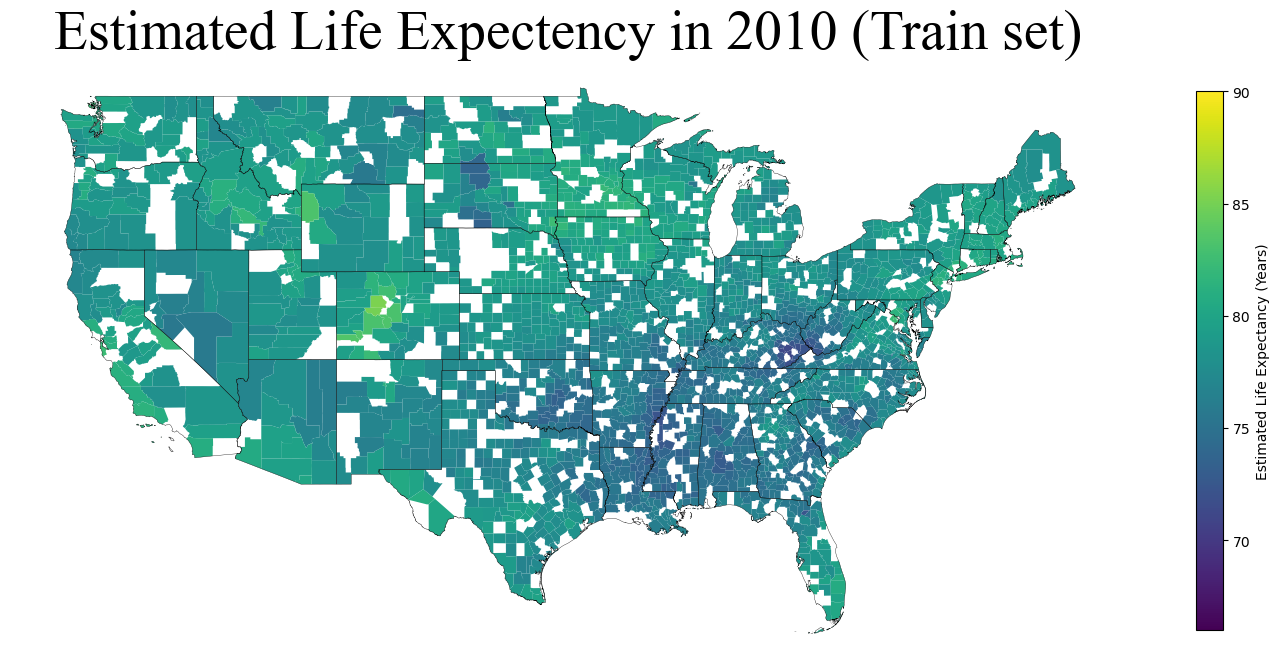

In [49]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_train.plot(ax=ax,column='Train Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010 (Train set)', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

In [50]:
df_test = pd.merge(full_df, ## merge index with original data
                    y_test_df, left_index=True, right_index=True, how='left') 
df_test.head()

,location_name,fips,year,MeanLifeExpectency,NAME,d2m,t2m,bcaod550,chnk,duaod550,lai_hv,lai_lv,msl,omaod550,pm2p5,pm10,ssaod550,asn,rsn,sd,suaod550,sp,tsn,aod550,tcco,tc_c2h6,tchcho,tc_oh,tc_c5h8,tc_ch4,tc_hno3,tcno2,tc_no,gtco3,tc_pan,tc_c3h8,tcso2,tcw,tcwv,aermssdus,aermssdum,aermssdul,aermssbchphil,aermssomhphil,aermssbchphob,aermssomhphob,aermsssss,aermssssm,aermssssl,aermsssu,aermssso2,Test Prediction
0,Autauga County (Alabama),1001,2010,75.728489,Autauga,283.451923,291.082855,0.006283,0.018000,0.010711,3.928166,2.633983,101693.582399,0.075980,1.446171e-08,1.982170e-08,0.007567,0.878742,271.152098,0.005543,0.071453,100184.300988,272.664958,0.171994,0.000890,0.000003,0.000004,4.876077e-09,0.000004,0.009891,0.000005,0.000003,4.665009e-07,0.006583,0.000009,6.955006e-07,0.000003,25.761255,25.615093,0.000002,0.000004,0.000003,1.284990e-07,0.000003,5.390204e-07,0.000013,2.303450e-07,0.000016,1.009535e-06,0.000008,0.000002,74.681047
1,Baldwin County (Alabama),1003,2010,77.826608,Baldwin,286.576288,292.203100,0.006440,0.015609,0.013566,4.173506,2.677024,101685.794860,0.073427,1.376687e-08,1.885521e-08,0.010250,0.879502,201.577644,0.005211,0.070358,101272.049634,274.177695,0.174040,0.000876,0.000003,0.000004,4.927685e-09,0.000002,0.010002,0.000005,0.000003,4.440812e-07,0.006439,0.000008,6.645245e-07,0.000002,27.814162,27.673807,0.000003,0.000005,0.000004,1.216744e-07,0.000002,5.625185e-07,0.000013,2.858056e-07,0.000021,1.940944e-06,0.000008,0.000001,75.102751
2,Barbour County (Alabama),1005,2010,75.841973,Barbour,284.030677,291.049553,0.006414,0.018000,0.010646,4.105077,2.401998,101691.374779,0.073921,1.517368e-08,2.077828e-08,0.007873,0.878999,248.936151,0.006123,0.067726,100206.359317,272.703123,0.166579,0.000885,0.000003,0.000004,4.877634e-09,0.000004,0.009894,0.000005,0.000003,4.403563e-07,0.006526,0.000009,6.843867e-07,0.000003,26.033231,25.892798,0.000002,0.000004,0.000003,1.435932e-07,0.000002,5.378396e-07,0.000013,2.381366e-07,0.000016,1.119412e-06,0.000008,0.000001,NaN
3,Bibb County (Alabama),1007,2010,73.705432,Bibb,283.399627,290.639088,0.006220,0.018000,0.010239,3.806542,2.708516,101697.654467,0.077070,1.473672e-08,2.024184e-08,0.007104,0.878525,274.633550,0.005328,0.073269,100126.232531,272.649834,0.173902,0.000894,0.000003,0.000004,4.880969e-09,0.000004,0.009884,0.000005,0.000004,5.119491e-07,0.006629,0.000009,7.059465e-07,0.000003,25.483006,25.334140,0.000002,0.000004,0.000003,1.258605e-07,0.000003,5.349512e-07,0.000013,2.197643e-07,0.000015,8.923379e-07,0.000008,0.000002,NaN
4,Blount County (Alabama),1009,2010,75.753407,Blount,282.901290,289.815983,0.006111,0.018000,0.008443,3.248142,2.783056,101709.279262,0.077202,1.520853e-08,2.099272e-08,0.006220,0.877274,276.605380,0.006145,0.074806,99117.579532,272.616992,0.172783,0.000889,0.000003,0.000004,4.892594e-09,0.000003,0.009779,0.000005,0.000004,5.297614e-07,0.006687,0.000009,7.184297e-07,0.000004,24.141938,23.988644,0.000002,0.000003,0.000003,1.289331e-07,0.000003,5.203605e-07,0.000013,1.997636e-07,0.000013,7.163518e-07,0.000008,0.000002,NaN


In [51]:
df_test = df_test[['fips', 'Test Prediction']] ## get only fips and test prediction
df_test=df_test.dropna()

In [52]:
plot_test = pd.merge(county_gdf, df_test, on='fips', how='left') 
plot_test= plot_test.dropna()
plot_test.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Test Prediction
6,0500000US01049,01,049,DeKalb,County,777.093,"POLYGON ((-85.57593 34.82373, -85.56142 34.750...",1049,75.394553
12,0500000US01077,01,077,Lauderdale,County,667.697,"POLYGON ((-87.29922 35.00092, -87.29918 35.000...",1077,75.031982
14,0500000US01001,01,001,Autauga,County,594.436,"POLYGON ((-86.52469 32.70706, -86.52443 32.707...",1001,74.681047
15,0500000US01003,01,003,Baldwin,County,1589.784,"POLYGON ((-87.41247 30.57386, -87.41271 30.573...",1003,75.102751
28,0500000US01055,01,055,Etowah,County,534.991,"POLYGON ((-86.13956 34.18699, -86.13313 34.186...",1055,75.180402


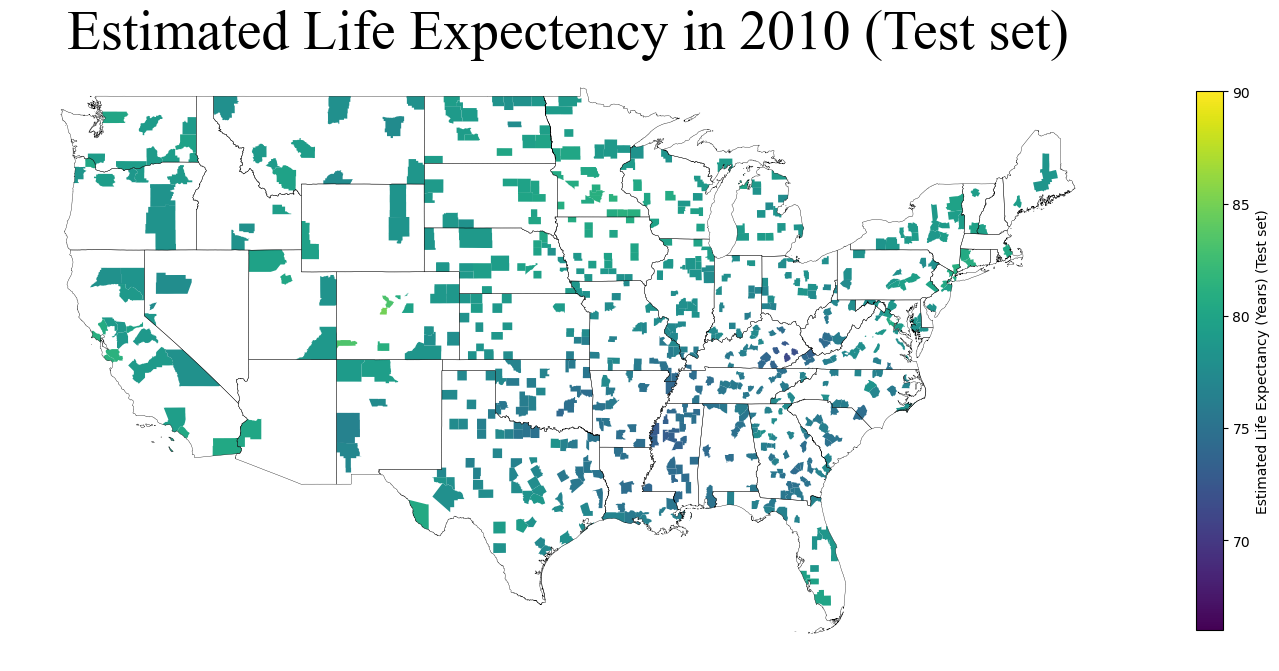

In [53]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
plot_test.plot(ax=ax,column='Test Prediction', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years) (Test set)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010 (Test set)', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

## Combine train and test set

In [54]:
plot_train=plot_train.rename(columns={"Train Prediction": "Estimated"})
plot_test=plot_test.rename(columns={"Test Prediction": "Estimated"})

final_df=pd.concat([plot_train, plot_test])
final_df = final_df[['fips', 'Estimated']]
final_df

,fips,Estimated
0,1029,74.878220
1,1031,75.832746
2,1037,75.040147
3,1039,74.870888
4,1041,74.599575
...,...,...
3116,55133,79.600896
3119,55141,80.574946
3120,56009,78.383431
3123,56005,78.379229


In [55]:
combined_plot = pd.merge(county_gdf, final_df, on='fips', how='left') 
combined_plot=combined_plot.dropna()

combined_plot

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry,fips,Estimated
0,0500000US01029,01,029,Cleburne,County,560.100,"POLYGON ((-85.38872 33.91304, -85.38088 33.873...",1029,74.878220
1,0500000US01031,01,031,Coffee,County,678.972,"POLYGON ((-86.03044 31.61894, -86.00408 31.619...",1031,75.832746
2,0500000US01037,01,037,Coosa,County,650.926,"POLYGON ((-86.00928 33.10164, -86.00917 33.090...",1037,75.040147
3,0500000US01039,01,039,Covington,County,1030.456,"POLYGON ((-86.34851 30.99434, -86.35023 30.994...",1039,74.870888
4,0500000US01041,01,041,Crenshaw,County,608.840,"POLYGON ((-86.14699 31.68045, -86.14711 31.663...",1041,74.599575
...,...,...,...,...,...,...,...,...,...
3138,0500000US56027,56,027,Niobrara,County,2626.037,"POLYGON ((-104.05298 42.85955, -104.05286 42.7...",56027,78.231033
3139,0500000US56031,56,031,Platte,County,2084.208,"POLYGON ((-104.77417 42.60996, -104.76422 42.6...",56031,78.388656
3140,0500000US56037,56,037,Sweetwater,County,10426.649,"POLYGON ((-109.05008 41.00066, -109.17368 41.0...",56037,78.056576
3141,0500000US56043,56,043,Washakie,County,2238.549,"POLYGON ((-107.12892 43.99455, -107.12797 43.9...",56043,78.294650


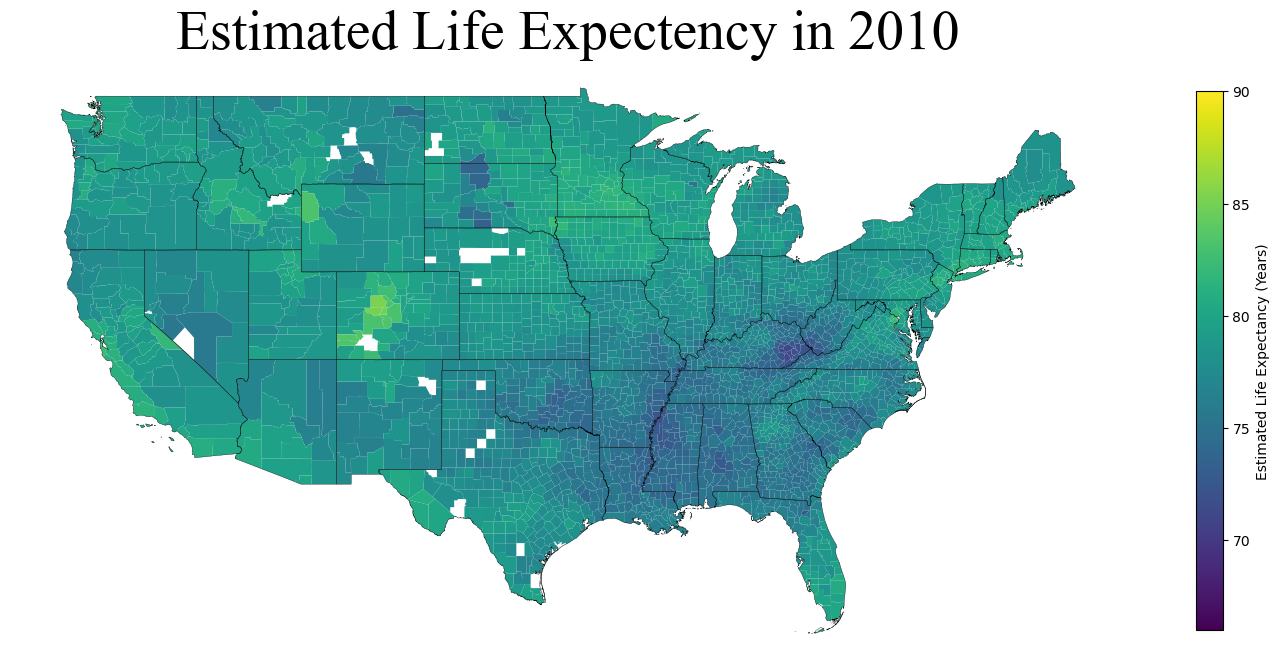

In [56]:
fig, ax = plt.subplots(1, figsize=(18, 14))
ax.axis('off') ## remove axis box from map 


## plot the county shape file
combined_plot.plot(ax=ax,column='Estimated', legend=True, legend_kwds={"label": "Estimated Life Expectancy (Years)", 
                                                                                   "shrink":0.50}, vmin=66, vmax=90)
hfont = {'fontname':'Times New Roman'}

## overlay state shapefile
state_shape.plot(facecolor='none', edgecolor='black', ax=ax, linewidth=0.25)

# add a title and annotation
ax.set_title('Estimated Life Expectency in 2010', **hfont, fontdict={'fontsize': '40', 'fontweight' : '1'})

plt.show()

# Lets calculate the prediction with small number of features

In [57]:
## select the top number of features from permutation feature importance

columns=['msl', 'suaod550', 'duaod550', 'tcwv', 'lai_lv', 't2m', 'd2m', 'tcw', 'ssaod550', 'tsn',
                'rsn', 'gtco3','lai_hv', 'asn', 'tc_ch4', 'aod550', 'sd', 'sp', 'aermssssm']

features=full_df[columns]
features

,msl,suaod550,duaod550,tcwv,lai_lv,t2m,d2m,tcw,ssaod550,tsn,rsn,gtco3,lai_hv,asn,tc_ch4,aod550,sd,sp,aermssssm
0,101693.582399,0.071453,0.010711,25.615093,2.633983,291.082855,283.451923,25.761255,0.007567,272.664958,271.152098,0.006583,3.928166,0.878742,0.009891,0.171994,0.005543,100184.300988,0.000016
1,101685.794860,0.070358,0.013566,27.673807,2.677024,292.203100,286.576288,27.814162,0.010250,274.177695,201.577644,0.006439,4.173506,0.879502,0.010002,0.174040,0.005211,101272.049634,0.000021
2,101691.374779,0.067726,0.010646,25.892798,2.401998,291.049553,284.030677,26.033231,0.007873,272.703123,248.936151,0.006526,4.105077,0.878999,0.009894,0.166579,0.006123,100206.359317,0.000016
3,101697.654467,0.073269,0.010239,25.334140,2.708516,290.639088,283.399627,25.483006,0.007104,272.649834,274.633550,0.006629,3.806542,0.878525,0.009884,0.173902,0.005328,100126.232531,0.000015
4,101709.279262,0.074806,0.008443,23.988644,2.783056,289.815983,282.901290,24.141938,0.006220,272.616992,276.605380,0.006687,3.248142,0.877274,0.009779,0.172783,0.006145,99117.579532,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,101612.298364,0.023680,0.004273,7.862793,0.521521,278.306938,268.699994,7.935474,0.004944,268.952507,288.800929,0.006922,2.963378,0.797428,0.007670,0.081071,0.016638,78671.597311,0.000012
3123,101622.979506,0.021002,0.001595,6.340060,2.378314,273.873965,267.448043,6.433924,0.005779,268.553249,309.101498,0.007037,2.573796,0.806610,0.007256,0.077760,0.099861,74693.719536,0.000012
3124,101650.473089,0.023933,0.002633,7.547265,0.512830,277.146315,269.879659,7.626590,0.005739,269.200462,291.005009,0.006890,3.884682,0.805558,0.007502,0.081755,0.030315,77019.435348,0.000013
3125,101430.695846,0.022530,0.003667,8.856018,0.494686,279.434588,269.946087,8.928365,0.004885,269.545441,286.108717,0.007060,4.857899,0.784556,0.008058,0.088080,0.009852,82493.849881,0.000013


In [58]:
target=full_df['MeanLifeExpectency'].copy()
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [59]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.57


In [60]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=4, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()

In [61]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')

RMSE scores for each fold: [1.44014673 1.56303598 1.5606272  1.55493992]
Mean RMSE score: 1.529687459591938
Standard deviation of RMSE scores: 0.05177987263461527


In [62]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'max_features': [5, 10,20,30], 'max_depth':[100, 150, 200, 300],
                                                              'min_samples_split':[5, 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
CPU times: total: 33min 9s
Wall time: 3min 19s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150, 200, 300],
                          'max_features': [5, 10, 20, 30],
                          'min_samples_split': [5, 10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [63]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=300, max_features=5, min_samples_split=10,
                      n_jobs=-1, oob_score=True)

In [64]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [65]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.87


In [66]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.61


In [67]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.28


In [68]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.87


In [69]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.69


In [70]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.86
The adjusted test r_sq ::: 0.68


In [71]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

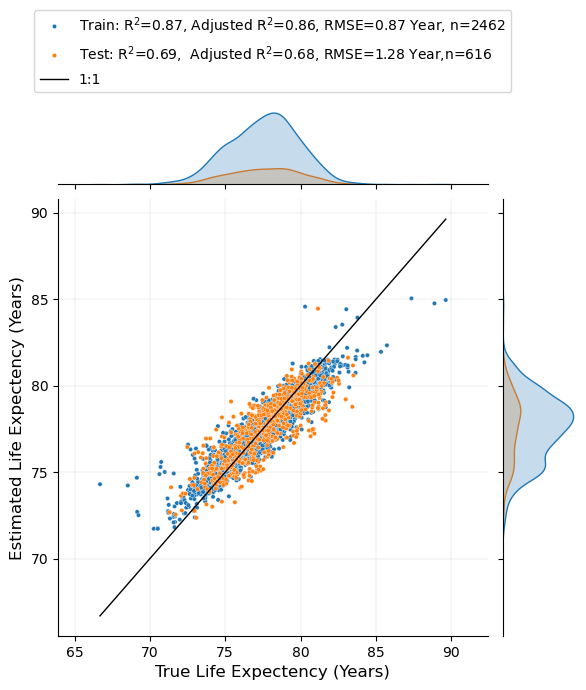

In [72]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  



g.ax_joint.legend(handles=handles,  
    labels=[ f'Train: R$^2$={corr_train}, Adjusted R$^2$={train_adjusted_r2}, RMSE={rmse_train} Year, n={len(X_train)}', 
        f'Test: R$^2$={corr_test},  Adjusted R$^2$={test_adjusted_r2}, RMSE={rmse_test} Year,n={len(X_test)}','1:1'],
                        title=None)

sns.move_legend(g.ax_joint, "upper center", bbox_to_anchor=(0.5, 1.45))

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

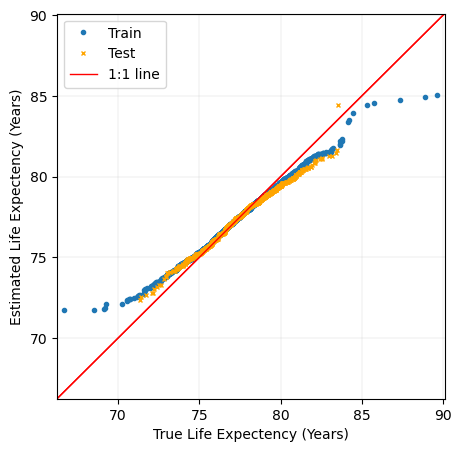

In [73]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

In [74]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

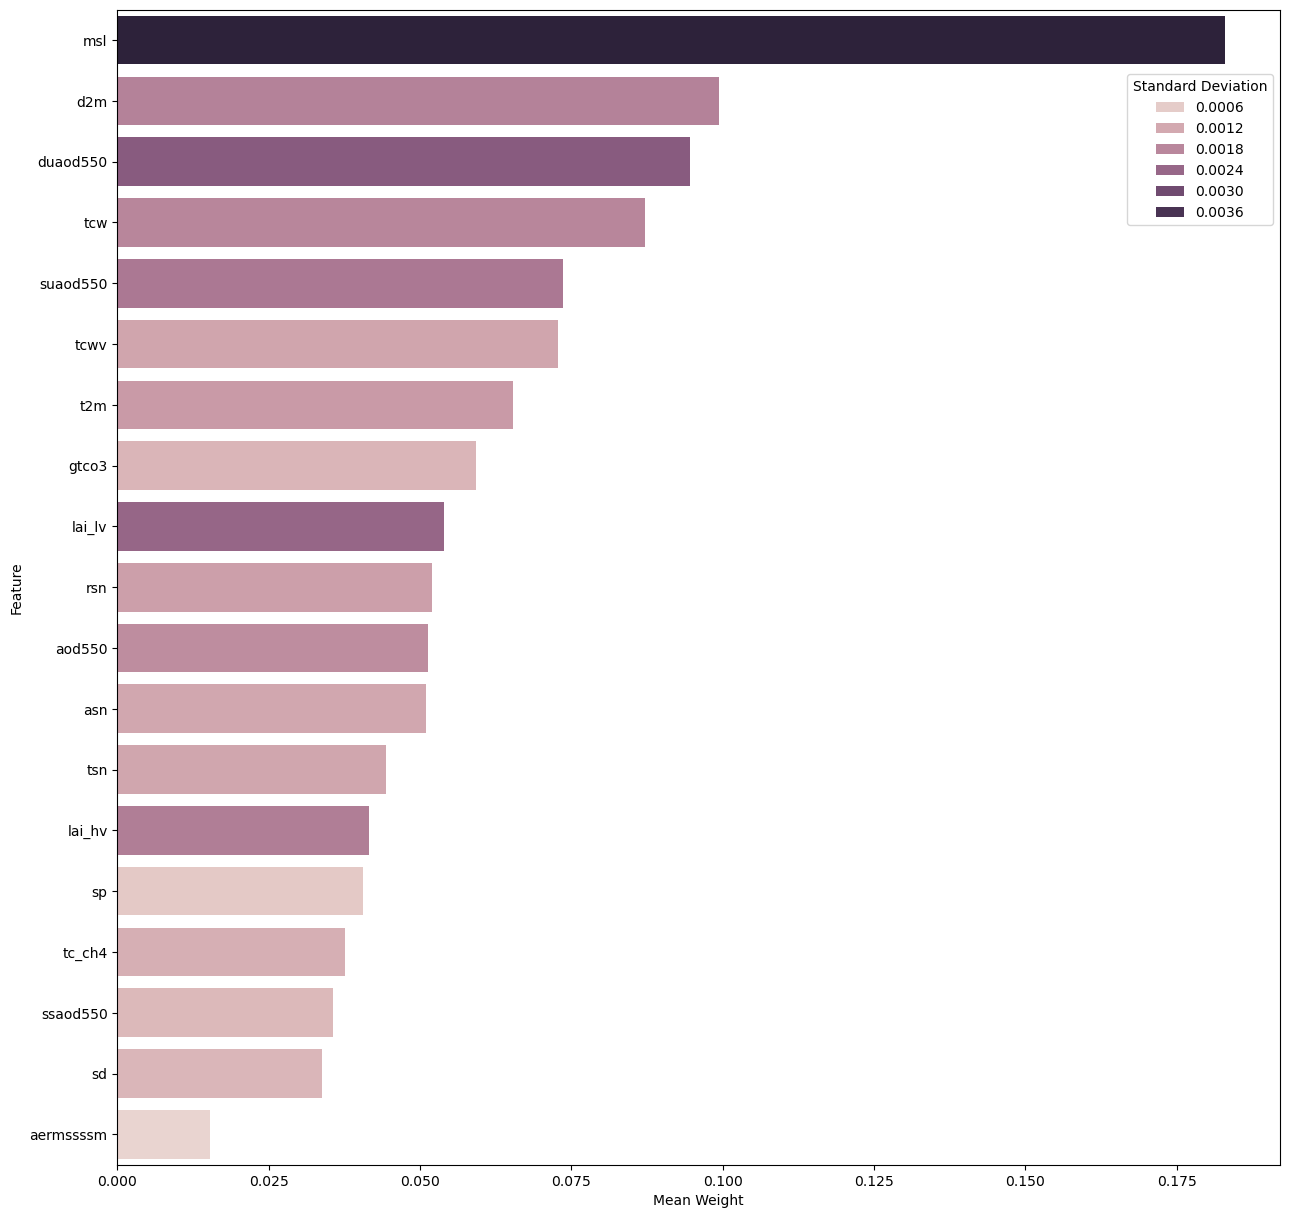

In [75]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.95))

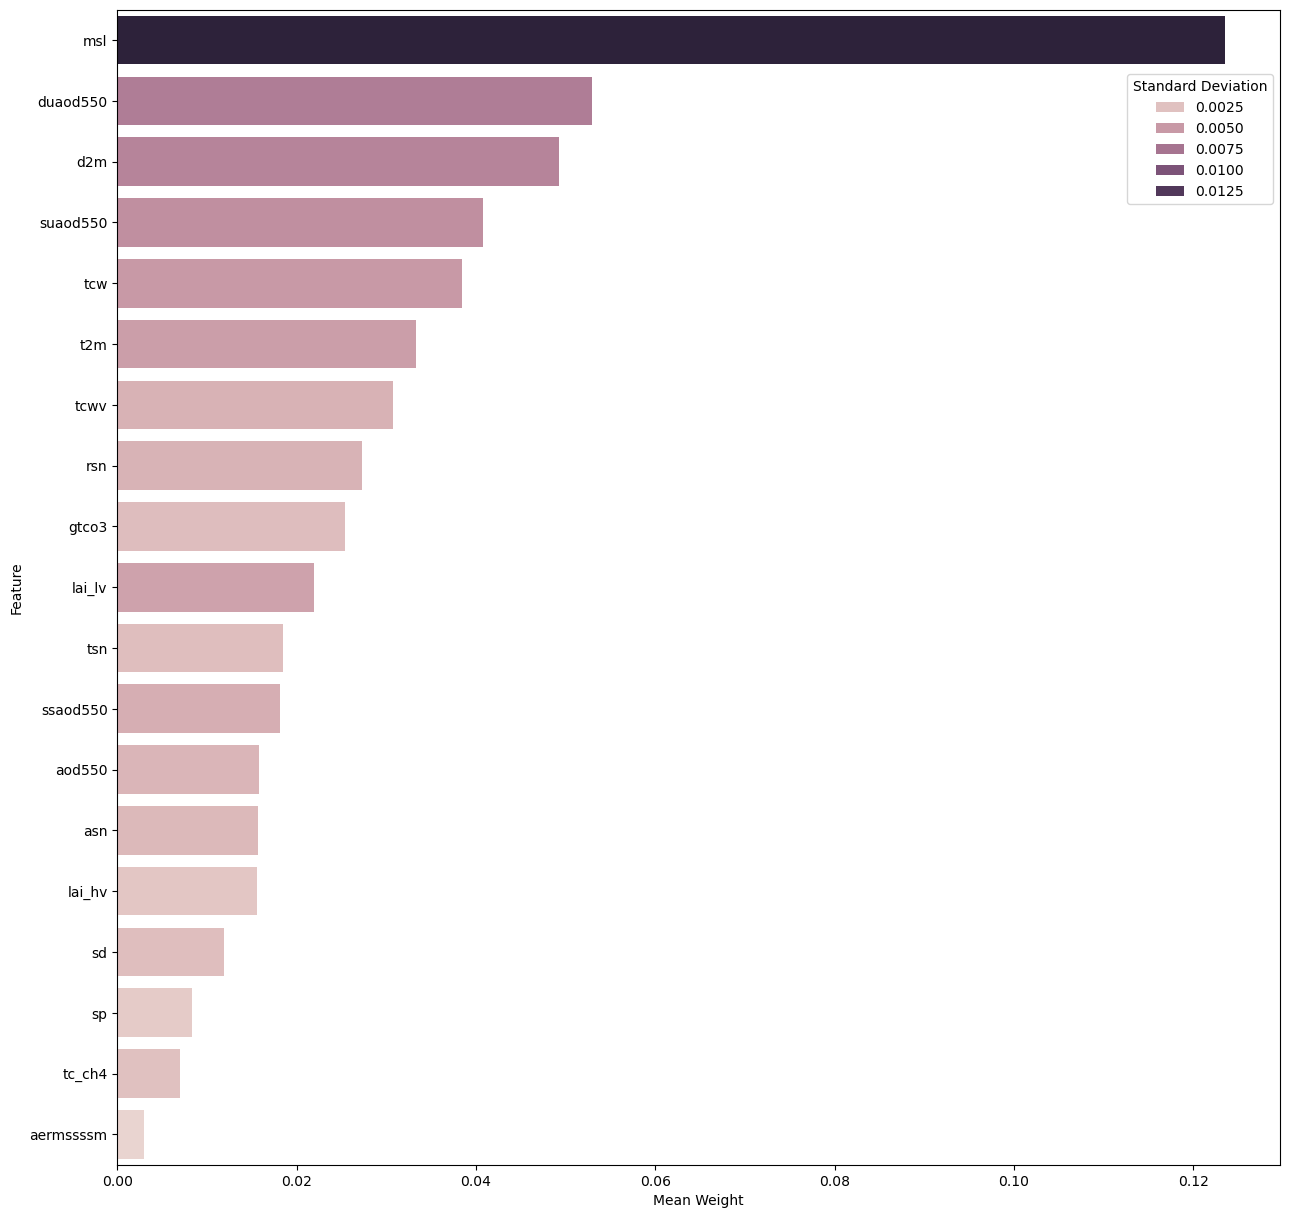

In [76]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5

mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.95))

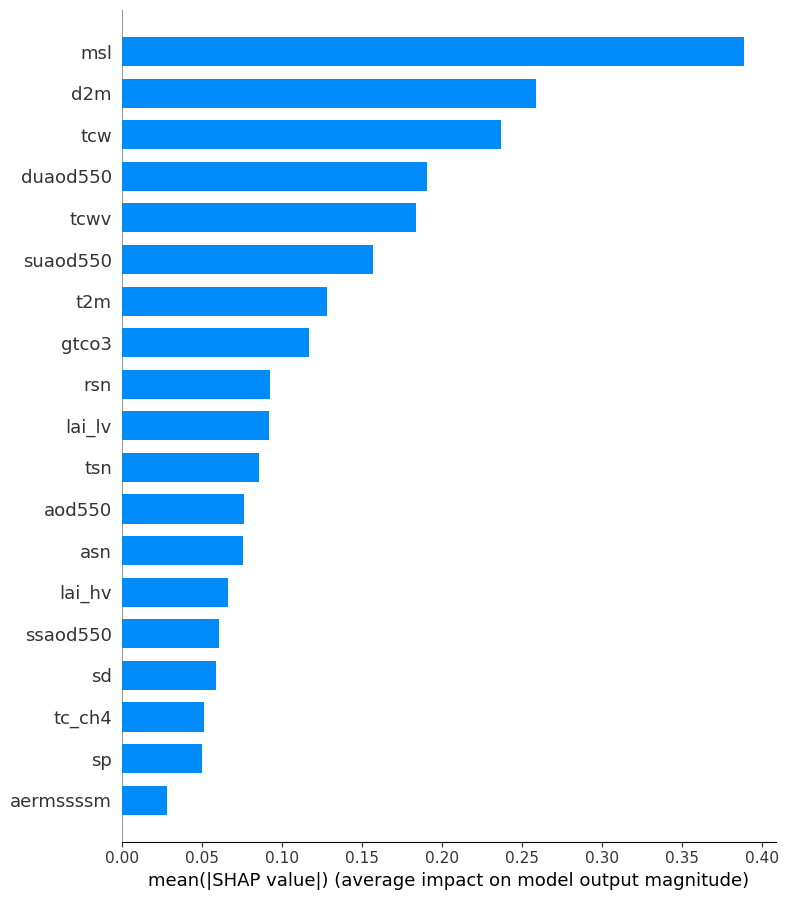

In [77]:
## in train set

shap_values = shap.TreeExplainer(final_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()

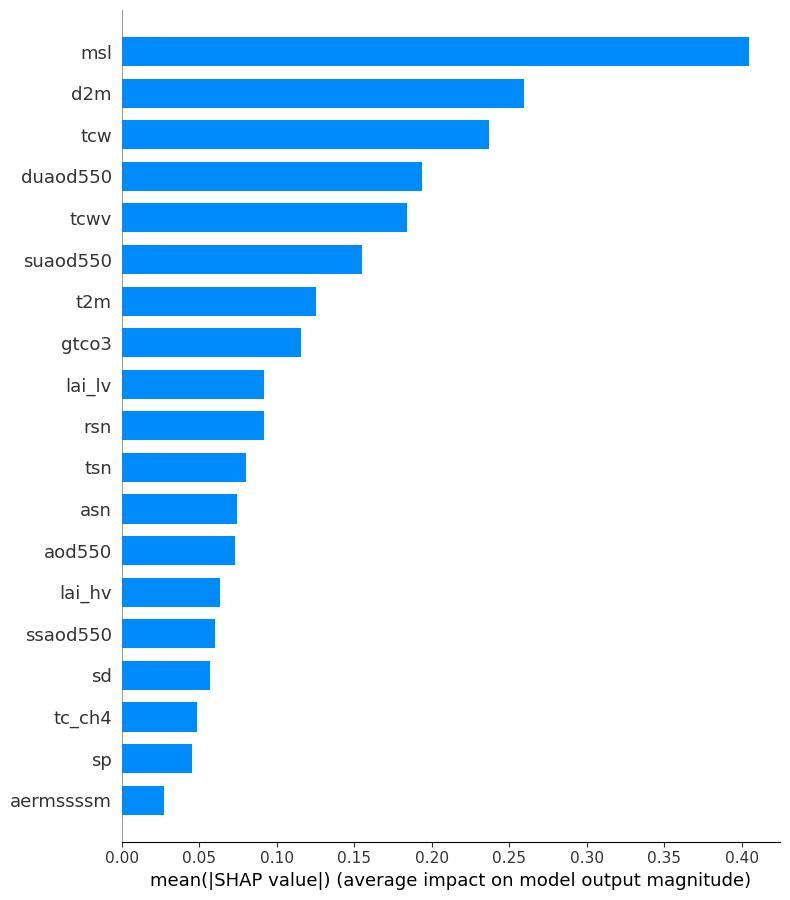

In [78]:
## in test set
shap_values = shap.TreeExplainer(final_model).shap_values(X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=46)
plt.show()